In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math

# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix

In [2]:
def calc_acc(annoy_indices, knn_indices, k):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res2 = []
    for a in aa:
        acc2 = 0
        for i in range(len(a)):
            acc2 += a[i]
        if not len(a):
            res2.append(0)
        else:
            res2.append(acc2/len(a))
    return np.array(res2).mean()
def calc_nDCG(annoy_indices, knn_indices, k, discount = 3):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res = []
    for a in aa:
        acc = 0
        for i in range(len(a)):
            acc += a[i]/math.log(i+6, 7)
        if not len(a):
            res.append(0)
        else:
            res.append(acc/len(a))
    return np.array(res).mean()


## loading data

In [3]:
entekhab = pd.read_csv('./pages_entekhab.csv')
entekhab.head(20)

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
0,761039,2020-08-09 03:40:44.820172+04:30,"{0.264251947402954,-0.644542038440704,-0.18412...",یادداشت‌های علم، شنبه ۲۴ مرداد ۱۳۴۹: ایادی ما ...,entekhab.ir/fa/news/495749/%DB%8C%D8%A7%D8%AF%...,2,t,f,f,t,28054354,73,"{3.626948595047,0.779965162277222,0.8395900726...",602.0,{23}
1,2754181,2020-09-26 03:50:01.442172+03:30,"{0.273704349994659,-0.830473184585571,-0.28864...",ايران همچنان همان امپراتوری پارس است / عربستا...,entekhab.ir/fa/news/266708/%D8%A7%D9%8A%D8%B1%...,2,t,f,f,t,37476083,73,"{1.13415098190308,-1.20623469352722,-0.6013424...",621.0,{15}
2,4286495,2020-10-03 10:35:21.85205+03:30,"{0.853439688682556,-0.564931094646454,-0.37323...",همه آنچه برای ترامپ در شب گذشته رخ داد؛ از تنگ...,entekhab.ir/fa/news/577730/%D9%87%D9%85%D9%87-...,2,t,f,t,t,38017087,73,"{2.13742733001709,-1.12283325195312,-0.3791791...",1530910.0,{15}
3,4875542,2020-10-10 09:40:15.864975+03:30,"{1.15192973613739,-0.138078510761261,0.6881629...",پیکر ۲ جانباخته ریزش ساختمان در در خیابان ابوذ...,entekhab.ir/fa/news/578944/%D9%BE%DB%8C%DA%A9%...,2,t,f,t,t,38559541,73,"{0.230344951152802,0.131352335214615,0.9686161...",1758716.0,{21}
4,536136,2020-08-09 03:29:13.257136+04:30,"{0.704237043857574,-1.47816872596741,0.4682139...",7تن گوشت چرخ کرده با سنگدون مرغ یخ زده و چربی ...,entekhab.ir/fa/news/434541/7%D8%AA%D9%86-%DA%A...,2,t,f,t,t,29837398,73,"{3.626948595047,0.779965162277222,0.8395900726...",750.0,{22}
5,926557,2020-08-09 03:48:27.715412+04:30,"{-0.272317439317703,0.354126185178757,0.105726...",ویدیو / دری نجف آبادی: ممکن است FATF از دستور ...,entekhab.ir/fa/news/553636/%D9%88%DB%8C%D8%AF%...,2,t,f,f,t,27251139,73,"{3.626948595047,0.779965162277222,0.8395900726...",NaN,{23}
6,2679316,2020-09-19 21:33:51.475395+04:30,"{0.808205783367157,-0.969625532627106,-0.40755...",تا زمان برگزاری انتخابات آمریکا و بیان صریح مو...,entekhab.ir/fa/news/575411/%D8%AA%D8%A7-%D8%B2...,2,t,f,t,t,36975475,73,"{1.24864614009857,-1.19327878952026,-0.5599737...",1324.0,{15}
7,4286727,2020-10-03 10:45:24.947041+03:30,"{0.853987216949463,-0.202528178691864,-0.49360...",رئیس پلیس تهران: ارسال اشتباهی پیامک‌های حجاب ...,entekhab.ir/fa/news/577736/%D8%B1%D8%A6%DB%8C%...,2,t,f,t,t,38018045,73,"{1.85497891902924,0.154068395495415,-0.8957029...",1531042.0,{15}
8,464068,2020-08-09 03:25:58.532063+04:30,"{-1.08582651615143,0.0488543212413788,0.038908...",ویدیو / توضیحات رئیس دفتر رئیس جمهور درمورد سن...,entekhab.ir/fa/news/560545/%D9%88%DB%8C%D8%AF%...,2,t,f,f,t,30691160,73,"{3.626948595047,0.779965162277222,0.8395900726...",NaN,{23}
9,502039,2020-08-09 03:27:52.377476+04:30,"{0.598500967025757,-0.519518435001373,-0.30455...",دیگر در تهران تخت خالی برای بستری بیمار کرونای...,entekhab.ir/fa/news/559856/%D8%AF%DB%8C%DA%AF%...,2,t,f,t,t,30236589,73,"{3.626948595047,0.779965162277222,0.8395900726...",1720.0,{-1}


In [4]:
print(entekhab.shape)

(65246, 15)


In [5]:
entekhab = entekhab[entekhab.included == 't']
entekhab.shape

(65243, 15)

In [6]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load('./entekhab.ir/view_matrix/item_indexer.indexer')
        self.user_indexer = AppendIndexer.load('./entekhab.ir/view_matrix/user_indexer.indexer')
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

## colaborative filtering train

In [7]:
def CFTrain(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 2, 
                      item_min_view = 2)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./entekhab.ir/alisResult/ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./entekhab.ir/alisResult/ali_user_indexer_factorized.indexer')
    np.save('./entekhab.ir/alisResult/ali_items_vectors.npy', als_model.item_vectors)
    np.save('./entekhab.ir/alisResult/ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors

In [8]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors = \
CFTrain('./entekhab.ir/view_matrix/lil_matrix.npz', factors = 20)

View matrix loaded in 8.30119013786316 seconds.
Number of users which should be deleted: 1784866
Number products which should be deleted: 26556
Number of users which should be deleted: 2255
Number products which should be deleted: 155
Number of users which should be deleted: 77
Number products which should be deleted: 4
Number of users which should be deleted: 2
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 31.284900426864624 seconds.

ALS model is fitted in 27.0700581073761 seconds.
Saving Data ...


In [9]:
sparce_matrix40, implicit_matrix40, item_vectors40, user_vectors40 = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 40)

View matrix loaded in 7.697247505187988 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 18.039303064346313 seconds.

ALS model is fitted in 151.85550355911255 seconds.
Saving Data ...


In [10]:
# implicit_matrix = implicit_matrix.toarray()
# sparce_matrix = sparce_matrix.toarray()

In [11]:
sparce_matrix.shape

(2097150, 32766)

In [12]:
implicit_matrix.shape

(309950, 6051)

## KNN Models

In [13]:
def sk_KNN(item_vectors, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    
    return knn_distances_brute, knn_indices_brute

In [14]:
def sk_KNN_c(item_vectors, mapper, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    a = [[mapper[j] for j in i]for i in knn_indices_brute]
    
    return knn_distances_brute, a

In [15]:
def get_annoy_results(pages_vector, number_of_trees = 170, number_of_neighbours = 30):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [16]:
def get_annoy_results_c(pages_vector, number_of_trees = 170, number_of_neighbours = 30):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(300, 'angular')
    
    for index, vector in pages_vector.items():
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for j, i in pages_vector.items():
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

## Runing KNN collaborative filtering

In [17]:
annoy_indices_CF, annoy_distances, duration = get_annoy_results(item_vectors)
duration

annoy time: 5.3135316371917725


5.3135316371917725

In [18]:
knn_distances_brute, knn_indices_brute = sk_KNN(item_vectors)

ball_tree time: 1.2709918022155762


In [19]:
print(annoy_indices_CF[3000])
print(knn_indices_brute[3000])

[3000, 3229, 2838, 2330, 35, 3144, 2083, 108, 1892, 2127, 949, 88, 1742, 64, 1820, 3317, 19, 3153, 2361, 3906, 738, 66, 3668, 4321, 1225, 4314, 3066, 62, 457, 113]
[3000 3229 2838 3144 3066 1745 1582 2950 2742 2775 5603 2023 2609 3746
 2887 3095 4501 1035  139 5743 3444 5735 1909 2465  128 1890 1711 4482
 3415 3376]


In [20]:
item_indexer1 = \
AppendIndexer.load('./entekhab.ir/alisResult/ali_item_indexer_factorized.indexer')


In [21]:
entekhab[entekhab['id'] == int(item_indexer1.reverse_get(2838))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(3357))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(1364))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(800))]

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
5437,2137581,2020-08-09 04:49:17.716399+04:30,"{0.173560664057732,-0.0554969757795334,-0.1970...",استفاده از نسخه تحت وب اپلیکیشن های ایرانی؛ را...,entekhab.ir/fa/news/462086/%D8%A7%D8%B3%D8%AA%...,2,t,f,f,f,8939209,73,"{0.453929245471954,0.223702922463417,-0.408268...",338759.0,{}


## train content based

In [22]:
items = []
nulls = []
for i in item_indexer1.get_items():
    temp = {}
    try:
        item_index = item_indexer1.get(i)
        c_vec = np.array(entekhab[entekhab['id'] == int(i)].content_vector)[0]
        temp['content_vec'] = np.array([float(x) for x in str(c_vec)[1:-1].split(',')])
        temp['id'] = i
        temp['index'] = item_index
        items.append(temp)
    except:
        nulls.append(item_index)

In [23]:
pages_vector = []
indexer = AppendIndexer()

for i, j in entekhab.iterrows():
    try:
        a = {}
        a['content_vec'] = np.array([float(x) for x in str(j.content_vector)[1:-1].split(',')])
        a['index'] = indexer.get_or_create(j.id)
        a['id'] = j.id
        pages_vector.append(a)
    except:
        continue

In [24]:
item_content_map = {}
for i in pages_vector:
    item_content_map[i['index']] = i['content_vec']
content_vec = []
items_itex = []
for i, j in item_content_map.items():
    content_vec.append(j)
    items_itex.append(i)
# items_itex.index(1600)

In [25]:
len(item_content_map)

65028

In [26]:
annoy_indices_CB, annoy_distances_CB, duration_CB = get_annoy_results_c(item_content_map)

annoy time: 74.62292337417603


In [27]:
knn_distances_brute_CB, knn_indices_brute_CB = sk_KNN_c(content_vec, items_itex)

ball_tree time: 2231.5141026973724


In [28]:
print(annoy_indices_CB[6300])
print(knn_indices_brute_CB[6300])

[6300, 35190, 19857, 33089, 58324, 25402, 8173, 53222, 18482, 2262, 2978, 16903, 16102, 47302, 44238, 12171, 8502, 56252, 8934, 5847, 6469, 29543, 26468, 40673, 47978, 13485, 41630, 7592, 52532, 8736]
[6300, 35190, 19857, 33089, 8173, 2262, 18482, 12171, 44238, 16903, 56252, 8502, 48528, 27299, 29543, 7592, 58324, 27031, 55592, 53829, 25402, 8934, 26468, 6469, 52538, 2978, 15598, 31147, 9883, 47978]


In [29]:
entekhab[entekhab['id'] == int(item_indexer1.reverse_get(6000))]

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
30283,2146378,2020-08-09 04:49:42.016839+04:30,"{-0.438678175210953,-0.621124267578125,0.40196...",عکس/ جرج بوش و همسرش مدال آزادی گرفتند,entekhab.ir/fa/news/440496/%D8%B9%DA%A9%D8%B3-...,2,t,f,f,f,4810874,73,"{0.467156141996384,-0.378140717744827,0.702701...",NaN,{}


## Annoy accuracy

In [30]:
Tknn_distances_brute, Tknn_indices_brute = sk_KNN(item_vectors40, number_of_neighbours = 10)

ball_tree time: 2.14823579788208


In [31]:
for i in [5, 10, 30, 50, 70, 100, 150, 200, 300]:
    Tannoy_indices_CF, Tannoy_distances, Tduration = get_annoy_results(item_vectors40, number_of_trees = i, number_of_neighbours = 10)
    print(calc_acc(Tannoy_indices_CF, Tknn_indices_brute, 10))

annoy time: 0.12083578109741211
0.2526295380737725
annoy time: 0.28519105911254883
0.2730518798571729
annoy time: 0.39673590660095215
0.28591278496760536
annoy time: 0.6796019077301025
0.28823938086698014
annoy time: 0.9081199169158936
0.2883524792787553
annoy time: 1.3718392848968506
0.2888048729258559
annoy time: 2.221330165863037
0.28909569741327773
annoy time: 2.8976893424987793
0.288934128253599
annoy time: 4.317365884780884
0.28911185432924563


In [32]:
Aknn_distances_brute_CB, Aknn_indices_brute_CB = sk_KNN_c(content_vec, items_itex, number_of_neighbours = 10)

ball_tree time: 2673.7734825611115


In [36]:
alltime = []
allndcg = []
for i in range(20):    
    tt = []
    accs = []
    ndcgs = []
    trees = [5, 6, 7, 9, 10, 12, 15, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300]
    for i in trees:
        Tannoy_indices_CB, Tannoy_distances_CB, Tduration_CB = get_annoy_results_c(item_content_map, number_of_trees = i, number_of_neighbours = 10)
        tt.append(65243/Tduration_CB)
        accs.append(calc_acc(Tannoy_indices_CB, Aknn_indices_brute_CB, 10))
        ndcgs.append(calc_nDCG(Tannoy_indices_CB, Aknn_indices_brute_CB, 10))
    alltime.append(tt)
    allndcg.append(ndcgs)
alltime = np.array(alltime)
allndcg = np.array(allndcg)

annoy time: 14.455398082733154
annoy time: 15.104038000106812
annoy time: 14.851196050643921
annoy time: 15.751535415649414
annoy time: 15.4863920211792
annoy time: 16.712255239486694
annoy time: 17.87536644935608
annoy time: 19.44169330596924
annoy time: 24.58332872390747
annoy time: 28.21495008468628
annoy time: 32.068522453308105
annoy time: 41.80151414871216
annoy time: 50.37809872627258
annoy time: 41.81574773788452
annoy time: 67.75437641143799
annoy time: 80.07449245452881
annoy time: 87.66035890579224
annoy time: 105.21986651420593
annoy time: 121.46500515937805
annoy time: 14.425283670425415
annoy time: 14.395758867263794
annoy time: 15.420397758483887
annoy time: 15.64036774635315
annoy time: 15.951899290084839
annoy time: 16.505470991134644
annoy time: 17.26614236831665
annoy time: 19.49825167655945
annoy time: 25.0516619682312
annoy time: 28.832855701446533
annoy time: 33.50415658950806
annoy time: 41.10990929603577
annoy time: 52.57036995887756
annoy time: 59.2269878387451

annoy time: 7.629342317581177
annoy time: 7.345685243606567
annoy time: 8.727514266967773
annoy time: 11.665206909179688
annoy time: 13.584568738937378
annoy time: 15.87637972831726
annoy time: 21.296730756759644
annoy time: 29.060667991638184
annoy time: 33.58569931983948
annoy time: 44.999292612075806
annoy time: 51.077986001968384
annoy time: 52.783324003219604
annoy time: 65.04684066772461
annoy time: 78.25925707817078
annoy time: 6.562215089797974
annoy time: 6.942564249038696
annoy time: 7.036862373352051
annoy time: 7.238830089569092
annoy time: 7.310265064239502
annoy time: 7.4739460945129395
annoy time: 8.047801494598389
annoy time: 9.944437026977539
annoy time: 12.944469928741455
annoy time: 15.288249254226685
annoy time: 17.953239917755127
annoy time: 24.863529443740845
annoy time: 30.296748638153076
annoy time: 35.21902632713318
annoy time: 39.411733865737915
annoy time: 45.00329041481018
annoy time: 50.31759428977966
annoy time: 61.20713210105896
annoy time: 72.25416254997

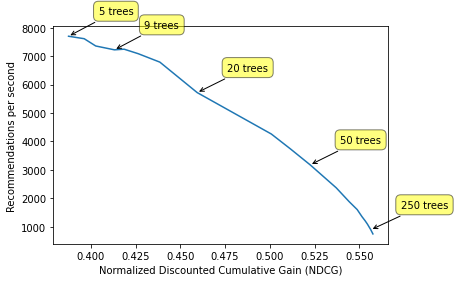

In [44]:
plt.plot(np.mean(allndcg, axis= 0), np.mean(alltime, axis = 0))
plt.ylabel("Recommendations per second")
plt.xlabel("Normalized Discounted Cumulative Gain (NDCG)")
for i in [0,3,7,10,17]:
    plt.annotate(
            str(trees[i]) + " trees",
            xy=(np.mean(allndcg, axis= 0)[i], np.mean(alltime, axis = 0)[i]), xytext=(30, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

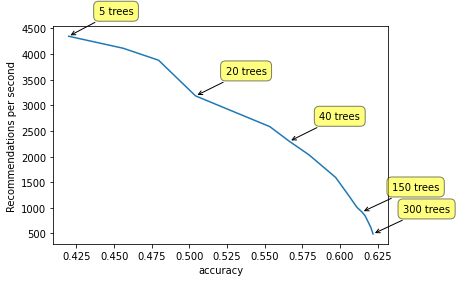

In [35]:
plt.plot(accs, tt)
plt.ylabel("Recommendations per second")
plt.xlabel("accuracy")
for i in [0,3,5,10,14]:
    plt.annotate(
            str(trees[i]) + " trees",
            xy=(accs[i], tt[i]), xytext=(30, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [63]:
print(tt)
print(accs)
print(ndcgs)

NameError: name 'tt' is not defined

## Precision Recall @k and MAE

In [28]:
now = time.time()
aproximated_matrix = np.matmul(user_vectors, np.transpose(item_vectors))
time.time() - now

19.879060983657837

In [30]:
start = time.time()
# implicit_matrix = implicit_matrix.toarray()
absolute_error = abs(aproximated_matrix - implicit_matrix)
time.time() - start

232.96968388557434

In [31]:
start = time.time()
MAE = absolute_error.mean()
time.time() - start

71.03863096237183

In [32]:
MAE

0.009043916284864414

In [27]:
idk = []
for i in tqdm(range(len(implicit_matrix))):
    temp = []
    for j in range(len(implicit_matrix[i])):
        if implicit_matrix[i][j] > 0:
            temp.append((implicit_matrix[i][j], j))
    idk.append(temp)

100%|██████████| 233197/233197 [18:19<00:00, 212.01it/s]


In [41]:
idk2 = []
for i in tqdm(range(len(aproximated_matrix))):
    temp = []
    for j in range(len(aproximated_matrix[i])):
        if aproximated_matrix[i][j] > 0.3:
            temp.append((aproximated_matrix[i][j], j))
    idk2.append(temp)

100%|██████████| 233197/233197 [15:20<00:00, 253.30it/s]


In [80]:
for i in tqdm(range(len(idk2))):
    idk2[i] = sorted(idk2[i], key=lambda x: x[0], reverse=True)

100%|██████████| 233197/233197 [00:00<00:00, 263142.36it/s]


In [86]:
def Precision_recall_at_k(idk2, idk, k):
    users_visited_indeces = \
    [[i[1] for i in idk[j]] for j in range(len(idk))]
#     print(users_visited_indeces[0:10])
    recommended_relevant = []
    relevants = []
    for i in range(len(idk2)):
        temp = 0
        if len(idk2[i]) >= k and len(users_visited_indeces[i]) >= k:
            for j in range(len(idk2[i][0:k+1])):
                if idk2[i][j][1] in users_visited_indeces[i]:
                    temp += 1
            recommended_relevant.append(temp)
            relevants.append(len(users_visited_indeces[i]))
    p = (np.array(recommended_relevant) / k).mean()
    r = []
    for i in zip(recommended_relevant, relevants):
        r.append(i[0]/i[1])
    r = np.array(r).mean()
    return p, r

In [87]:
for k in range(1, 20):
    print('k =', k, Precision_recall_at_k(idk2, idk, k))

k = 1 (0.7186354499231405, 0.3132991983320419)
k = 2 (0.45802332358454406, 0.39563191122090663)
k = 3 (0.3964406552864489, 0.33340775120759264)
k = 4 (0.3518457896857373, 0.28333117710725014)
k = 5 (0.3264939622252039, 0.2523960932844422)
k = 6 (0.31026053776903356, 0.231139391231143)
k = 7 (0.30018033558099416, 0.2186396367495723)
k = 8 (0.29234575087310827, 0.20980850487899763)
k = 9 (0.2872784150156413, 0.204103039836464)
k = 10 (0.2821524064171123, 0.1993732143623082)
k = 11 (0.27719190208605954, 0.1940893510669637)
k = 12 (0.2746406570841889, 0.19230763612031124)
k = 13 (0.2700897117770567, 0.18766172434375045)
k = 14 (0.2647549530761209, 0.1844010920044037)
k = 15 (0.25830429732868754, 0.17646792331281605)
k = 16 (0.2542162698412698, 0.17401698465680013)
k = 17 (0.24929360390444388, 0.17363907796836417)
k = 18 (0.244718792866941, 0.17004162464521388)
k = 19 (0.24428718855963436, 0.1696894556403601)
